In [1]:
%matplotlib notebook

In [2]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import base
from IPython.display import display, HTML
import math
import time
import matplotlib.animation as animation


In [4]:
points_recep = sc.read.json('datos/train-test-by-emission.jsonlines/').rdd

In [5]:
birds_recep = sc.read.json('datos/day-birds.jsonlines/').rdd
birds_recep = birds_recep.sortBy(lambda x: x['timestamp'])

[Row(recep_0=0, recep_1=58, recep_2=0, recep_3=0, tag_id=24, timestamp='2018-01-20 00:00:00')]

## Map utils

In [6]:
global posicion_antenas
posicion_antenas = [(463512.015195402,6111004.324434620),(464259.981343845,6110331.85100085),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]

global x_0
global y_0

x_0 = 462385.503783397
x_f = 465958.114906211
y_0 = 6109042.35153865
y_f = 6112715.80637111


def normalize_positions(row):
    row['x'] = row['x']-x_0
    row['y'] = row['y']-y_0
    return row

def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)


In [7]:
def group_emisions(data):
    data_dict = data.asDict()
    recep_0 = data_dict.pop('recep_0')
    recep_1 = data_dict.pop('recep_1')
    recep_2 = data_dict.pop('recep_2')
    recep_3 = data_dict.pop('recep_3')
    
    data_dict['emissions'] = []
    for i in range(24):
        data_dict['emissions'].append([recep_0[i], recep_1[i], recep_2[i], recep_3[i]])
    return data_dict


In [8]:
points_emisions = points_recep.map(group_emisions)


In [9]:
def expand_rows_with_emissions(row):
    emissions = row.pop('emissions')
    rows = []
    for e in emissions:
        new_row = row.copy()
        new_row['recep'] = e
        rows.append(new_row)
    return rows
        
all_emissions = points_emisions.flatMap(expand_rows_with_emissions)

### Genero los atributos y etiquetas que me interesan

In [10]:
def generate_attrs(row):
    data = {
        'antenna_0': row['recep'][0],
        'antenna_1': row['recep'][1],
        'antenna_2': row['recep'][2],
        'antenna_3': row['recep'][3],
    }
    return {'data': data, 'x': row['x'], 'y': row['y'], 'point': row['Punto']}
    
all_emissions = all_emissions.map(generate_attrs)

### Saco las emisiones sin ninguna recepcion

In [11]:
all_emissions = all_emissions.filter(lambda x: sum(x['data'].values())>0)

### Normalizo coordenadas

In [12]:
all_emissions = all_emissions.map(lambda x: normalize_positions(x))

### Regresion por eje

In [13]:
regre_target = pd.DataFrame(all_emissions.map(lambda x: [x['x'], x['y']]).collect())
regre_data = pd.DataFrame(all_emissions.map(lambda x: x['data']).collect())



clf = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=5, weights='distance'))

clf.fit(regre_data, regre_target)


MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='distance'),
           n_jobs=None)

# Error analysis

### Mapa con el movimiento predicho para un pajaro

In [14]:
def update_animation(data, p):
    x = data[0]
    y = data[1]
    p.set_data(x, y)   
    return p
 

def show_birds_movement(predictions, delay=200):
    fig, ax = plt.subplots()
    point, = ax.plot([0], [0], 'go', color='red')
    point.set_data(0, 0)
    plt.ylim(0,y_f-y_0)
    plt.xlim(0,x_f-x_0)
    all_points_pos = pd.DataFrame(points_recep.map(lambda p: {'x': p['x'], 'y': p['y']}).map(normalize_positions).collect())
    plt.scatter(all_points_pos['x'], all_points_pos['y'], c='#96EAE1', s=10)
    for antenna in range(4):
            pos_antena = posicion_antenas[antenna]
            plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
    ani = animation.FuncAnimation(fig, update_animation, predictions, interval=delay, fargs=(point,))


In [15]:
BIRD_TAG_ID = 33
DELAY = 200


single_bird = birds_recep.filter(lambda x: x['tag_id'] == BIRD_TAG_ID)
birds_data = pd.DataFrame(single_bird.collect()).drop(columns=[4,5])

<IPython.core.display.Javascript object>


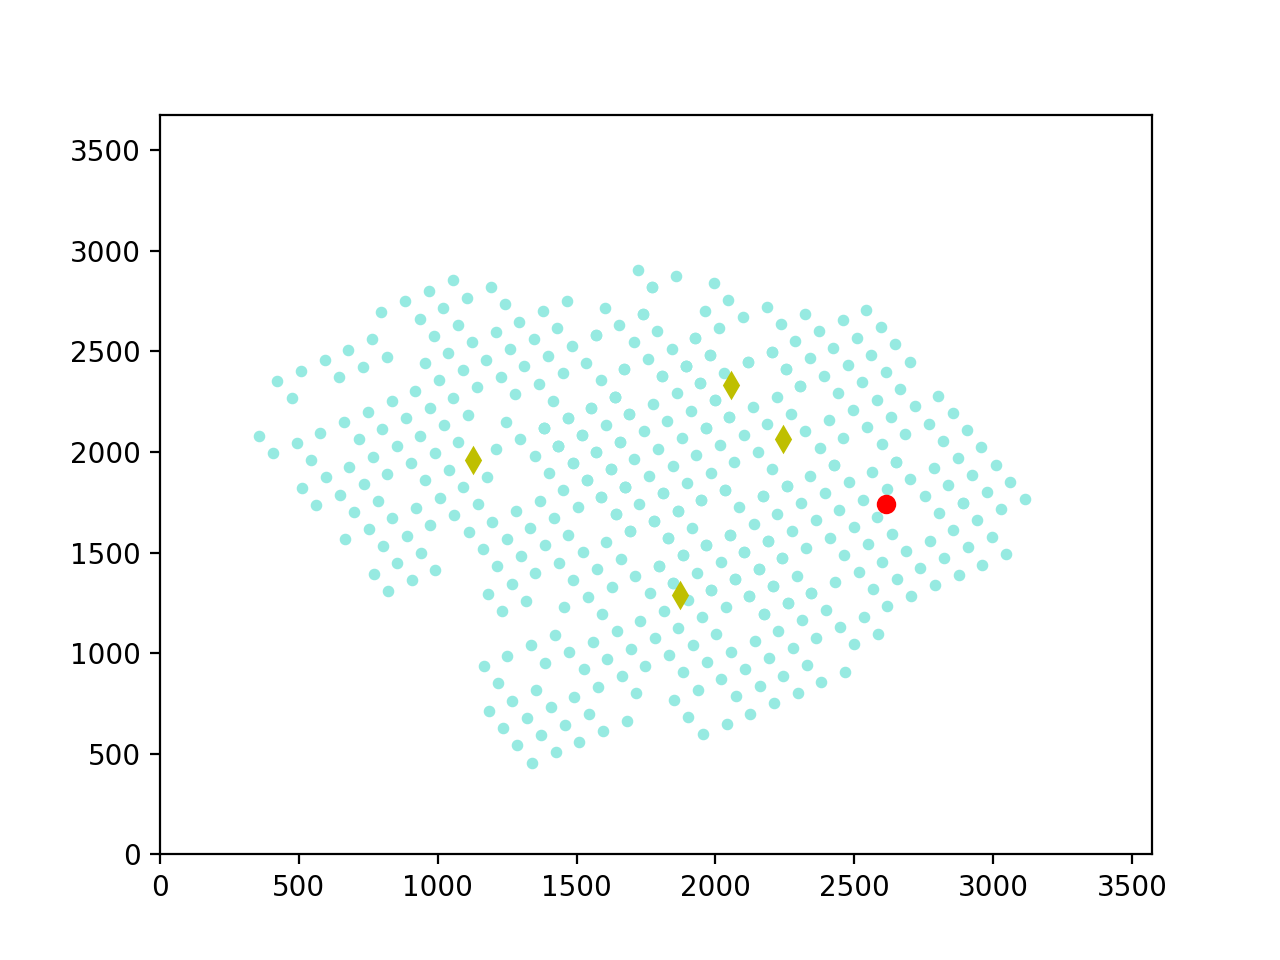

In [19]:
predictions = clf.predict(birds_data)
#show_birds_movement(predictions)

fig, ax = plt.subplots()
point, = ax.plot([0], [0], 'go', color='red')
point.set_data(0, 0)
plt.ylim(0,y_f-y_0)
plt.xlim(0,x_f-x_0)
all_points_pos = pd.DataFrame(points_recep.map(lambda p: {'x': p['x'], 'y': p['y']}).map(normalize_positions).collect())
plt.scatter(all_points_pos['x'], all_points_pos['y'], c='#96EAE1', s=10)
for antenna in range(4):
        pos_antena = posicion_antenas[antenna]
        plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
ani = animation.FuncAnimation(fig, update_animation, predictions, interval=DELAY, fargs=(point,), repeat=False)



In [30]:
single_bird = birds_recep.filter(lambda x: x['tag_id'] == BIRD_TAG_ID)
birds_data = pd.DataFrame(single_bird.filter(lambda x: x['timestamp'] > '2018-01-20 14:00:03' and  x['timestamp'] < '2018-01-20 18:00:03').collect()).drop(columns=[4,5])

###  Mapa con el movimiento incluyendo stdev de la prediccion

In [31]:
from statsmodels.stats.weightstats import DescrStatsW
from matplotlib.patches import Ellipse

In [32]:
regre_data_pd = pd.DataFrame(regre_data)
regre_target_pd = pd.DataFrame(regre_target)


#### Calculo stdev del eje x

In [33]:
neigh_dist, neigh_ind = clf.estimators_[0].kneighbors(birds_data)

weights = base._get_weights(neigh_dist, 'distance')

stdev_x = []

for i in range(len(birds_data)):
    weighted_stats = DescrStatsW(regre_target_pd.iloc[neigh_ind[i]][0], weights=weights[i], ddof=0)
    stdev_x.append(weighted_stats.std)
    


#### Calculo stdev del eje y

In [34]:
neigh_dist, neigh_ind = clf.estimators_[1].kneighbors(birds_data)

weights = base._get_weights(neigh_dist, 'distance')

stdev_y = []

for i in range(len(birds_data)):
    weighted_stats = DescrStatsW(regre_target_pd.iloc[neigh_ind[i]][1], weights=weights[i], ddof=0)
    stdev_y.append(weighted_stats.std)
    


#### Calculo predicciones y le agrego los stdev

In [35]:


predictions = clf.predict(birds_data)

stdev_x_np = np.array(stdev_x).reshape(len(stdev_x),1)
stdev_y_np = np.array(stdev_y).reshape(len(stdev_y),1)

stdev_xy = np.concatenate((stdev_x_np,stdev_y_np), axis=1)

predictions_with_stdev = np.concatenate((predictions,stdev_xy), axis=1)

#### Grafico el mapa con las predicciones

In [36]:
def update_animation(data, p, circ):
    x = data[0]
    y = data[1]
    p.set_data(x, y)
    if len(data) > 2:
        stdev_x = data[2]
        stdev_y = data[2]
        circ.center = (x, y)
        circ.width = stdev_x
        circ.height = stdev_y
        
    return p

<IPython.core.display.Javascript object>


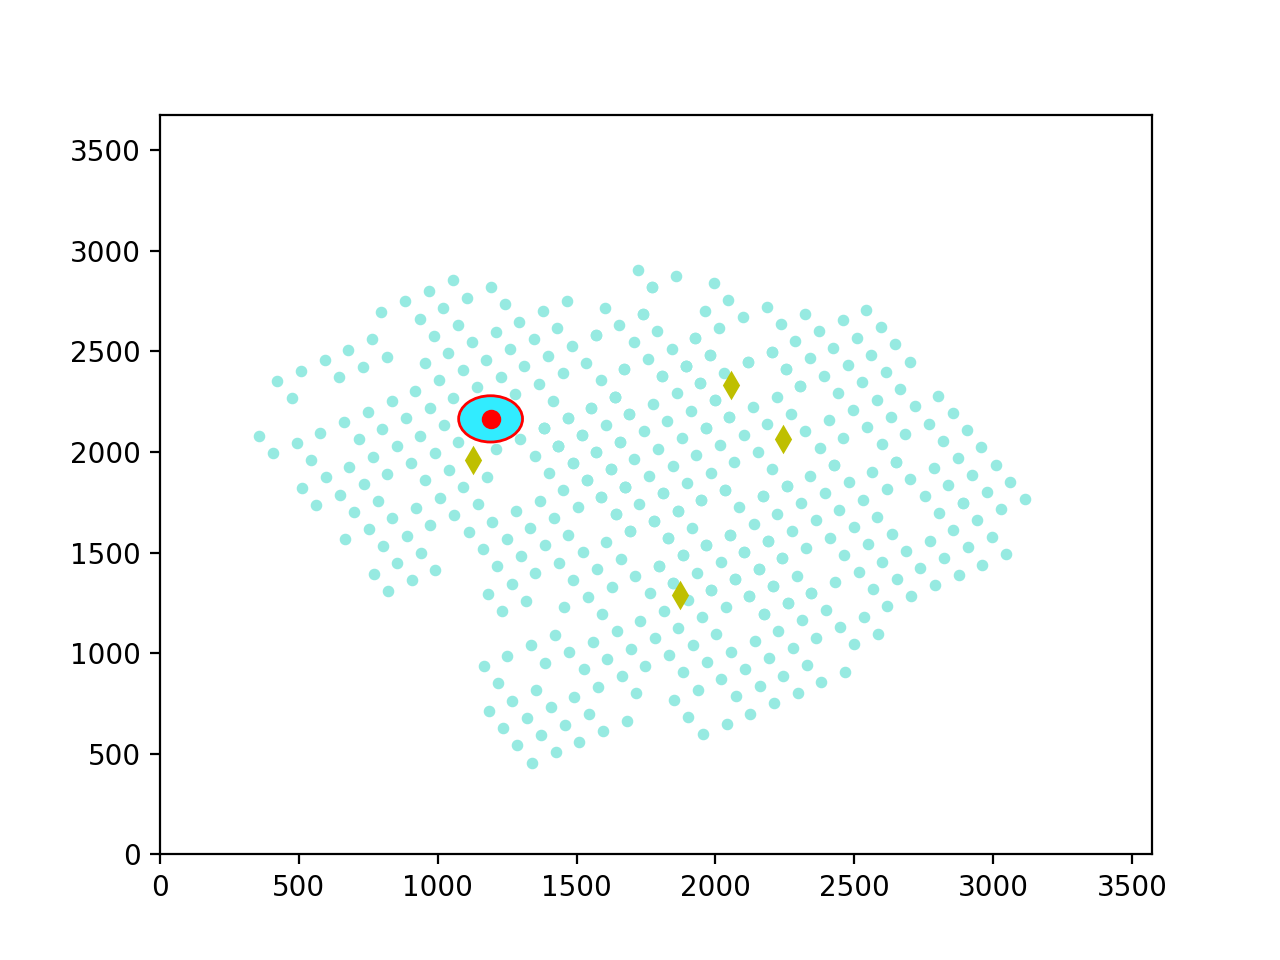

In [37]:
DELAY = 500
fig, ax = plt.subplots()
point, = ax.plot([0], [0], 'go', color='red')
point.set_data(0, 0)

circle = Ellipse((-1000, -1000), 0, 0, fill=True)
circle.set_edgecolor('red')
circle.set_facecolor('#31ecff')
ax.add_artist(circle)
 

plt.ylim(0,y_f-y_0)
plt.xlim(0,x_f-x_0)
all_points_pos = pd.DataFrame(points_recep.map(lambda p: {'x': p['x'], 'y': p['y']}).map(normalize_positions).collect())
plt.scatter(all_points_pos['x'], all_points_pos['y'], c='#96EAE1', s=10)
for antenna in range(4):
        pos_antena = posicion_antenas[antenna]
        plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
ani = animation.FuncAnimation(fig, update_animation, predictions_with_stdev, interval=DELAY, fargs=(point,circle,), repeat=False)



### Analisis de lo casos donde hay un salto de distancia grande entre dos emisiones

In [32]:
big_jumps = []
for i in range(1,len(predictions)):
    if distance(predictions[i-1], predictions[i]) > 1500:
        big_jumps.append(i)

In [33]:
big_jump_index = big_jumps[5]
birds_data[big_jump_index-5:big_jump_index+5]

,0,1,2,3
3295,39,0,0,0
3296,43,0,0,0
3297,43,0,0,0
3298,36,0,0,0
3299,0,0,0,31
3300,35,0,0,0
3301,0,24,0,0
3302,0,29,0,0
3303,0,37,0,0
3304,33,0,0,0


<IPython.core.display.Javascript object>


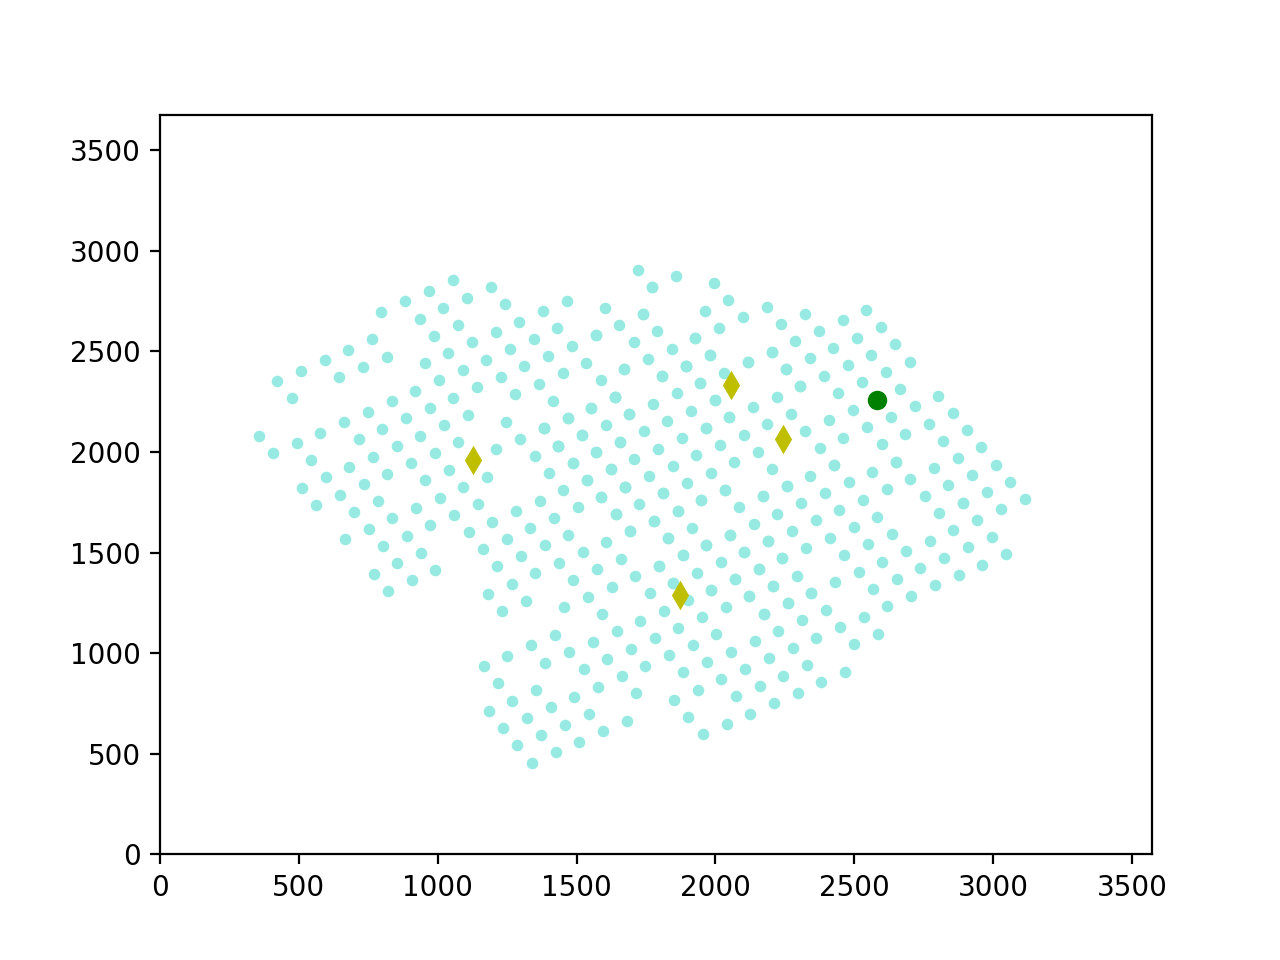

In [37]:
jump_pred = predictions[big_jump_index-20:big_jump_index+20]

fig, ax = plt.subplots()
point, = ax.plot([0], [0], 'go')
point.set_data(0, 0)
plt.ylim(0,y_f-y_0)
plt.xlim(0,x_f-x_0)
all_points_pos = pd.DataFrame(points_recep.map(lambda p: {'x': p['x'], 'y': p['y']}).map(normalize_positions).collect())
plt.scatter(all_points_pos['x'], all_points_pos['y'], c='#96EAE1', s=10)
for antenna in range(4):
        pos_antena = posicion_antenas[antenna]
        plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
ani = animation.FuncAnimation(fig, update_animation, jump_pred, interval=1000, fargs=(point,None,), repeat=False)



## Notas:

### Metodo usado para calcular weigthed stdev 

In [ ]:
a = regre_target_pd.iloc[neigh_ind[0]][1]
b = weights[0]

s = sum(b)
m = (a*b/s).sum()

res = 0
for i in range(len(a)):
    res += (a.iloc[i]-m)**2*b[i]/s
    
math.sqrt(res)